# Alireza Rashidi CI HW_3

## Data Preprations:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Datasets/train.zip /content/sample_data

In [3]:
!mkdir /content/CIHW3_Datasets
!unzip /content/sample_data/train.zip -d /content/CIHW3_Datasets

Archive:  /content/sample_data/train.zip
  inflating: /content/CIHW3_Datasets/train.csv  


In [5]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import datetime
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import torch.nn as nn
from torch import optim
from torch.nn.functional import one_hot
from torchvision.transforms import ToTensor
from tqdm import tqdm
from matplotlib import pyplot as plt

In [6]:
emotions = {
    0: 'Angry', 
    1: 'Disgust', 
    2: 'Fear', 
    3: 'Happy', 
    4: 'Sad', 
    5: 'Surprise', 
    6: 'Neutral'
}

df = pd.read_csv('/content/CIHW3_Datasets/train.csv')
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...
28704,2,84 85 85 85 85 85 85 85 86 86 86 87 86 86 91 9...
28705,0,114 112 113 113 111 111 112 113 115 113 114 11...
28706,4,74 81 87 89 95 100 98 93 105 120 127 133 146 1...
28707,0,222 227 203 90 86 90 84 77 94 87 99 119 134 14...


In [7]:
# torch.cuda.is_available()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [8]:
df.groupby('emotion').count()     # printing class frequencies.

,pixels
emotion,
0,3995
1,436
2,4097
3,7215
4,4830
5,3171
6,4965


## Custom Dataset

In [9]:
images = []
pixels = df['pixels']

# --------------------- pure tensor -------------------------------
for row in tqdm(range(len(pixels))):
    images.append([ int(x) for x in pixels[row].split(" ") ] )

100%|██████████| 28709/28709 [00:18<00:00, 1526.69it/s]


In [10]:
# this custom dataset used in order to batch data(with specific size) and preprocess each sample in run time.
class EmotionDetection_Dataset(torch.utils.data.Dataset):

    def __init__(self, X, y, transform=None, sample_size=(48, 48), num_classes=7, target_transform=True):
        self.X = torch.tensor(X)
        self.y = one_hot( torch.tensor(y), num_classes=num_classes) if target_transform else torch.tensor(y)  # one hot encoding for better classification accuracy
        self.transform = transform
        self.sample_size = sample_size

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        image = image.reshape(1, self.sample_size[0], self.sample_size[1]) 
        label = self.y[idx]

        if self.transform:   # normalize each sample dynamicly
            image = image / 255.

        return image, label


In [11]:
emotion_dataset = EmotionDetection_Dataset(images, df['emotion'], transform=True, target_transform=True)
print(len(emotion_dataset))

28709


## Data Visualizations:

Label:  Surprise


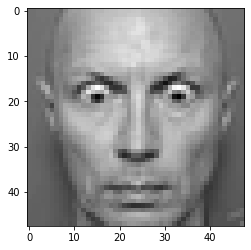

In [12]:
sample_idx = 15;
# plt.imshow(torch.squeeze( torch.transpose(train_X_tensor[sample_idx], 0, 2), 2 ) )
plt.imshow(torch.squeeze(emotion_dataset[sample_idx][0]), cmap="gray")
print('Label: ', emotions[emotion_dataset[sample_idx][1].argmax().item()])

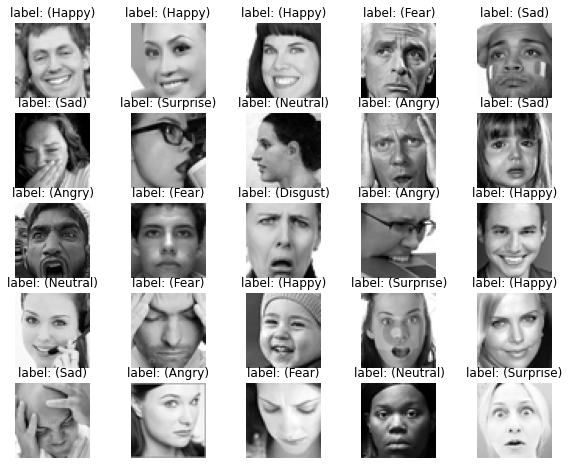

In [13]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(emotion_dataset), size=(1,)).item()
    img, label = emotion_dataset[sample_idx][0], emotions[emotion_dataset[sample_idx][1].argmax().item()]
    figure.add_subplot(rows, cols, i)
    plt.title('label: ({})'.format(label))
    plt.axis("off")
    plt.imshow(img.reshape(48, 48), cmap="gray")
plt.show()

## Train_validation_split:

In [14]:
random_seed = 42
torch.manual_seed(random_seed);

train_set_size = int(len(emotion_dataset) * 0.9)
valid_set_size = len(emotion_dataset) - train_set_size
train_set, valid_set = random_split(emotion_dataset, [train_set_size, valid_set_size])

In [15]:
print('train set len: ', len(train_set))
print('validation set len: ', len(valid_set))

train set len:  25838
validation set len:  2871


## Using Pytorch Dataloader for batching data:

In [16]:
# batching data + creating dataloader object for training CNN in pytorch framework. 
batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True) # we can itrate this object using iter and next in python.
val_dataloader = DataLoader(valid_set, batch_size)

In [17]:
print('batch images: ', iter(train_dataloader).next()[0].size())
print('batch labels: ', iter(train_dataloader).next()[1].size())

batch images:  torch.Size([64, 1, 48, 48])
batch labels:  torch.Size([64, 7])


In [18]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

one random batch from train_loader set (batch size = 64 ): 


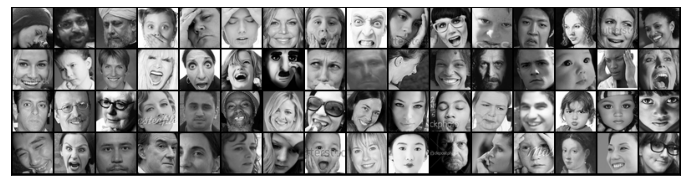

In [19]:
print('one random batch from train_loader set (batch size = {} ): '.format(batch_size) )
show_batch(train_dataloader)

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()   # torch.device
print(device)

cuda


## Test

In [21]:
diter = iter(train_dataloader)
images, labels = diter.next()

In [22]:
conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
x = conv1(images)
x = pool(x)
x = conv2(x)
x = pool(x)
x = pool(x)
x = pool(x)

print(x.shape)
print(images.shape)

torch.Size([64, 128, 3, 3])
torch.Size([64, 1, 48, 48])


In [23]:
x = x.view(x.size(0), -1)

In [24]:
l1 = nn.Linear(1152, 320)
l2 = nn.Linear(320, 64)
x = l1(x)
x = l2(x)
print(x.size())

torch.Size([64, 64])


## CNN Model:

In [46]:
class CNN(nn.Module):   
    def __init__(self, num_classes=7):
        super(CNN, self).__init__()

        self.cnn_layers = nn.Sequential(  # image shapes(1, 48, 48)
            # vgg-16 conv layer 1------(conv1)-----------
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # image size will be 

            # vgg-16 conv layer 2------(conv2)-----------
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # vgg-16 conv layer 3------(conv3)-----------
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # vgg-16 conv layer 4------(conv4)-----------
            # nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)

        )
        self.history = {'loss':[], 'val-loss':[]}

        self.linear_layers = nn.Sequential(

            nn.Linear(64 * 6 * 6, 1024),    # input features is (depth * h * w) , output feature is 128 
            nn.ReLU(),
            # nn.Dropout(p=0.30),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.30),
            nn.Linear(512, num_classes)
            )

    # Defining the forward pass (it's also prediction function)    
    def forward(self, x):
        x = self.cnn_layers(x)
        # flatten the output of conv layers to (batch_size, 512 * 3 * 3)
        x = x.view(x.size(0), -1)       
        output = self.linear_layers(x)
        return output

    def modelSummery(self):
        print(self)

In [58]:
cnn_model = CNN(num_classes=7).to(device)
print('CNN summery:\n')
cnn_model.modelSummery()

CNN summery:

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=2304, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, ou

### printing models parammeters:

In [59]:
for par in cnn_model.parameters():
    print(par)

Parameter containing:
tensor([[[[ 0.0191,  0.3097, -0.2204],
          [ 0.2904,  0.1466,  0.1455],
          [-0.1509,  0.3231, -0.1941]]],


        [[[ 0.0613,  0.0676, -0.1928],
          [ 0.2810, -0.2070,  0.0252],
          [ 0.2919, -0.1199, -0.3263]]],


        [[[ 0.1188, -0.0758,  0.0490],
          [ 0.3022, -0.0285, -0.1317],
          [-0.1806,  0.2358, -0.1865]]],


        [[[ 0.0976, -0.0119, -0.2699],
          [ 0.2174, -0.2062,  0.0924],
          [ 0.0418, -0.1238, -0.2971]]],


        [[[ 0.0424, -0.2372,  0.0264],
          [-0.1299,  0.0936,  0.0354],
          [ 0.1921,  0.2289, -0.2273]]],


        [[[ 0.3148,  0.1708,  0.0649],
          [ 0.0561, -0.0516,  0.3255],
          [-0.2490,  0.2266, -0.2563]]],


        [[[-0.1659, -0.0179, -0.1169],
          [ 0.0420,  0.1114,  0.2347],
          [ 0.1047,  0.0727,  0.1990]]],


        [[[ 0.2244,  0.2757, -0.1192],
          [ 0.0458,  0.1363, -0.0056],
          [-0.3112,  0.1956, -0.1702]]],


        [[

In [60]:
loss_func = nn.CrossEntropyLoss() 
opt = optim.Adam(cnn_model.parameters(), lr = 0.001)   
# opt2 = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
print(loss_func)
print(opt)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


In [61]:
def train(n_epoch, opt, model, loss_func, train_loader, log):    # implements pytorch's training loop. 
    for epoch in range(1, n_epoch + 1):
        loss_train = 0.0
        model.train()  # set the model to training mode.
        for batch_num, (images, labels) in enumerate(train_loader):

            images = images.to(device=device)     # moving batch of images to the gpu
            labels = labels.type(torch.FloatTensor)
            labels = labels.to(device=device)     # moving labels to the gpu

            preds = model(images)
            loss = loss_func(preds, labels)
            opt.zero_grad()
            loss.backward()     # calculates backprop
            opt.step()          # updates the model parammeters.

            loss_train += loss.item()
            if log:
                if epoch == 1 or epoch % 2 == 0:
                    print( '{} Epoch {}, Training loss: {}'.format(
                    datetime.datetime.now(), epoch, loss_train / len(train_loader)) )

        model.history['loss'].append(loss.item())   # appends loss on train set during training of model in each epoch.
        

In [62]:
train(50, opt, cnn_model, loss_func, train_dataloader, log=True)

Streaming output truncated to the last 5000 lines.
2021-12-06 15:47:56.658657 Epoch 26, Training loss: 0.055081471616383826
2021-12-06 15:47:56.683628 Epoch 26, Training loss: 0.05523868414139984
2021-12-06 15:47:56.707668 Epoch 26, Training loss: 0.055571734979011043
2021-12-06 15:47:56.731776 Epoch 26, Training loss: 0.05636823553555083
2021-12-06 15:47:56.756201 Epoch 26, Training loss: 0.05672590264884552
2021-12-06 15:47:56.781589 Epoch 26, Training loss: 0.057449676465279986
2021-12-06 15:47:56.805996 Epoch 26, Training loss: 0.05769186673483046
2021-12-06 15:47:56.830323 Epoch 26, Training loss: 0.05812436788536535
2021-12-06 15:47:56.854997 Epoch 26, Training loss: 0.05853447830765554
2021-12-06 15:47:56.877778 Epoch 26, Training loss: 0.05911302813651538
2021-12-06 15:47:56.902512 Epoch 26, Training loss: 0.05973034444274289
2021-12-06 15:47:56.926840 Epoch 26, Training loss: 0.05990440759918477
2021-12-06 15:47:56.951594 Epoch 26, Training loss: 0.060205262486297303
2021-12-0

In [64]:
cnn_model.history['loss']

[1.7633661031723022,
 1.5253044366836548,
 1.6423513889312744,
 1.4775460958480835,
 1.3237495422363281,
 1.2556911706924438,
 1.3408761024475098,
 1.0501329898834229,
 0.976395845413208,
 0.8208250403404236,
 0.7230644226074219,
 0.8644508719444275,
 0.3853583335876465,
 0.25689542293548584,
 0.4037923514842987,
 0.507977306842804,
 0.2763751149177551,
 0.1276707649230957,
 0.2060270756483078,
 0.10505685955286026,
 0.09160465747117996,
 0.06165440380573273,
 0.13150808215141296,
 0.15383979678153992,
 0.11297575384378433,
 0.27439314126968384,
 0.17110607028007507,
 0.051475536078214645,
 0.02578471042215824,
 0.11290497332811356,
 0.1177978515625,
 0.2805386483669281,
 0.09906527400016785,
 0.020913373678922653,
 0.09378670901060104,
 0.057148780673742294,
 0.06673797219991684,
 0.1593659520149231,
 0.1129058450460434,
 0.08973489701747894,
 0.11942876130342484,
 0.03084036335349083,
 0.03149888291954994,
 0.21329565346240997,
 0.028628161177039146,
 0.1365734040737152,
 0.162455648

Text(0, 0.5, 'loss')

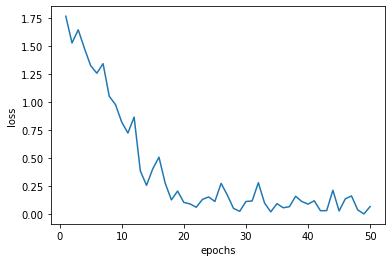

In [65]:
plt.plot(range(1, len(cnn_model.history['loss']) + 1), cnn_model.history['loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [33]:
# tst = iter(train_dataloader)
# batch = tst.next()
# batch_images , batch_labels = batch[0].to(device=device), batch[1].to(device=device)
# outputs = cnn_model(batch_images)

In [34]:
# batch_labels[3]

In [66]:
def validate(model, train_loader, val_loader):
    model.eval()
    val_acc = []
    train_acc = []

    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in loader:
                
                images = images.to(device=device)     # moving batch of images to the gpu
                labels = labels.type(torch.FloatTensor)
                labels = labels.to(device=device)     # moving labels to the gpu

                outputs = model(images)

                loss = loss_func(outputs, labels)

                predicted = outputs.argmax(axis=1)
                total += labels.shape[0]
                correct += int((predicted == labels.argmax(axis=1)).sum())
                # correct += int((predicted == labels).sum())

                print("Accuracy {}: {:.2f}".format(name , correct / total))

                if name == "train":
                    train_acc.append(correct / total)

                if name == "val":
                    val_acc.append(correct / total)
                    model.history['val-loss'].append(loss.item())
    return train_acc, val_acc

In [67]:
train_acc, val_acc = validate(cnn_model, train_dataloader, val_dataloader)

Accuracy train: 1.00
Accuracy train: 1.00
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.99
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy train: 0.98
Accuracy trai

Text(0, 0.5, 'loss')

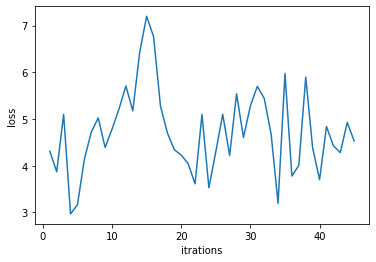

In [68]:
plt.plot(range(1, len(cnn_model.history['val-loss']) + 1), cnn_model.history['val-loss'])
plt.xlabel('itrations')
plt.ylabel('loss')

In [69]:
print('avg train accuracy: ', sum(train_acc)/len(train_acc))
print('\navg val accuracy: ', sum(val_acc)/len(val_acc))

avg train accuracy:  0.984770151280897

avg val accuracy:  0.5282832356312083


## saving model's parammeters:

In [70]:
torch.save(cnn_model.state_dict(), "/content/cnn_model_params.pt")